Make plots for the figures in Rader et al. 2023

In [1]:
import pickle
import numpy as np
from multiprocessing import Pool
import matplotlib
import matplotlib.pyplot as plt
import importlib as imp
import seaborn as sb
import cartopy.crs as ccrs

import experiments
import base_directories
import build_data
import save_load_model_run
import model_diagnostics
import metrics
import plots

In [2]:
exp_name = 'exp300'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()

In [3]:
settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp300.pickle
   analog data
 # analog samples = 5390
   training data
 # soi samples = 2310
   validation data
   # soi samples = 770
   testing data
  # soi samples = 770



## Get 50 years of predictions, and plot versus truth (Figure 3b)

In [4]:
# Get the mask
mask = model.get_layer("mask_model").get_layer("weights_layer").bias.numpy().reshape(analog_input[0].shape)

In [5]:
imp.reload(metrics)

n_processes = 8
n_analogues = 15
soi_input = soi_test_input
soi_output = soi_test_output

predictions = np.zeros((3, soi_input.shape[0])).T * np.nan

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    predictions[:,:]  = model_diagnostics.run_complex_operations(metrics.test_predictions,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)

[[0.1597199]]


Text(0.5, 1.0, 'Analog Predictions')

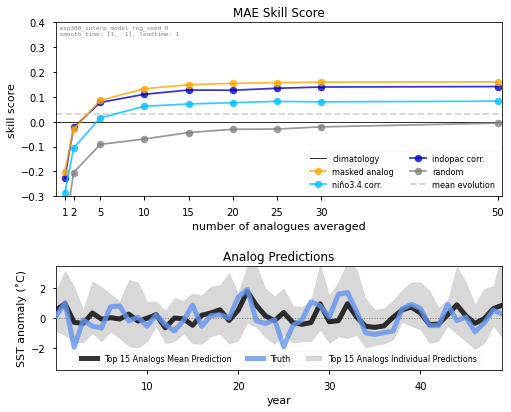

In [8]:
# MAKE SUMMARY PLOT ACROSS ALL MODEL TYPES
rng_string = settings["savename_prefix"][settings["savename_prefix"].find('rng'):]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4 * 1.6), gridspec_kw={'height_ratios': [5, 3], 'hspace' : .5})
i_rng, rng_string = 0, "rng_seed_0"

# GET THE METRICS DATA
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
    plot_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_analog_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_analog_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_metrics = pickle.load(f)

# PLOT THE METRICS
sub = plt.subplot(2, 1, 1)

n_analogs_list = np.array([1, 2, 5, 10, 15, 20, 25, 30, 50])
i_n_analogs = np.argwhere(n_analogs_list == n_analogues)

plots.summarize_skill_score(plot_metrics)

plot_ann_metrics = ann_analog_metrics
y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_network"][i_n_analogs]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
print(y_plot)
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.8, label="ann analog")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_persist"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.2, label="persistence")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_custom"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.5, label="custom")

plt.text(0.0, .99, ' ' + settings["exp_name"] + "_interp_model_" + rng_string + '\n smooth_time: ['
            + str(settings["smooth_len_input"]) + ', ' + str(settings["smooth_len_output"]) + '], leadtime: '
            + str(settings["lead_time"]),
            fontsize=6, color="gray", va="top", ha="left", fontfamily="monospace",
            transform=plt.gca().transAxes)
plt.grid(False)
plt.ylim(-.3, .4)

# Remove some lines
lines = sub.get_lines()
for line in [4, 6, 7]:
    lines[line].remove()

# Update some line labels
lines[0].set_label('climatology')
lines[2].set_label('niño3.4 corr.')
lines[3].set_label('indopac corr.')
lines[8].set_label('mean evolution')

# Change a color
lines[2].set_color('deepskyblue')
lines[3].set_color('mediumblue')
lines[8].set_color('lightgray')
lines[8].set_alpha(1)

# Change order
lines[8].set_zorder(0)
lines[3].set_zorder(0)

plt.legend(fontsize=8, loc=4, ncol=2)
plt.xticks(n_analogs_list)

###
### PREDICTIONS PART
###

plt.subplot(2, 1, 2)

fig_savename = 'Figure3'

start_year = 30
num_years = 50
end_year = start_year + num_years
analog_vals = predictions[start_year:end_year,0]
analog_mins = predictions[start_year:end_year,1]
analog_maxs = predictions[start_year:end_year,2]
truth_vals = soi_output[start_year:end_year]
#plt.figure(figsize=(8, 2.5))

linewidth = 5
alpha = .8

plt.axhline(0, zorder=0, color='gray', linestyle='dotted', alpha=1, linewidth=1)
plt.plot(analog_vals, label='Top 15 Analogs Mean Prediction', color='k', linewidth=linewidth, alpha=alpha, zorder=2)
plt.plot(truth_vals, label='Truth', color='cornflowerblue', linewidth=linewidth, alpha=alpha, zorder=3)
plt.fill_between(range(len(analog_mins)), analog_mins, analog_maxs, color='gray', alpha = .3, zorder=1,
                 label='Top 15 Analogs Individual Predictions')

plt.ylabel('SST anomaly (˚C)')
plt.xlabel('year')
plt.xlim(0, num_years-1)
plt.xticks(np.arange(10,num_years,(num_years//10 // 5)*10))
plt.yticks([-2, 0, 2])

plt.ylim(-3.5, 3.5)
plt.grid(False)
plt.legend(fontsize=8, ncol=3, loc="lower center",)
plt.title('Analog Predictions')
# plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
#                     '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

## Plot the Mask, plus the Mask times Input and Best Analog (Figure 2)

In [89]:
imp.reload(metrics)
imp.reload(plots)

# Get the mask
mask = model.get_layer("mask_model").get_layer("weights_layer").bias.numpy().reshape(analog_input[0].shape)

In [90]:
n_processes = 8
n_analogues = 15
soi_input = soi_test_input
soi_output = soi_test_output

best_analog_maps = np.zeros(soi_input.shape) * np.nan

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    best_analog_maps  = model_diagnostics.run_complex_operations(metrics.get_best_analog,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)

In [91]:
sample_num = 51
analog_map = best_analog_maps[sample_num]
soi_map = soi_input[sample_num]

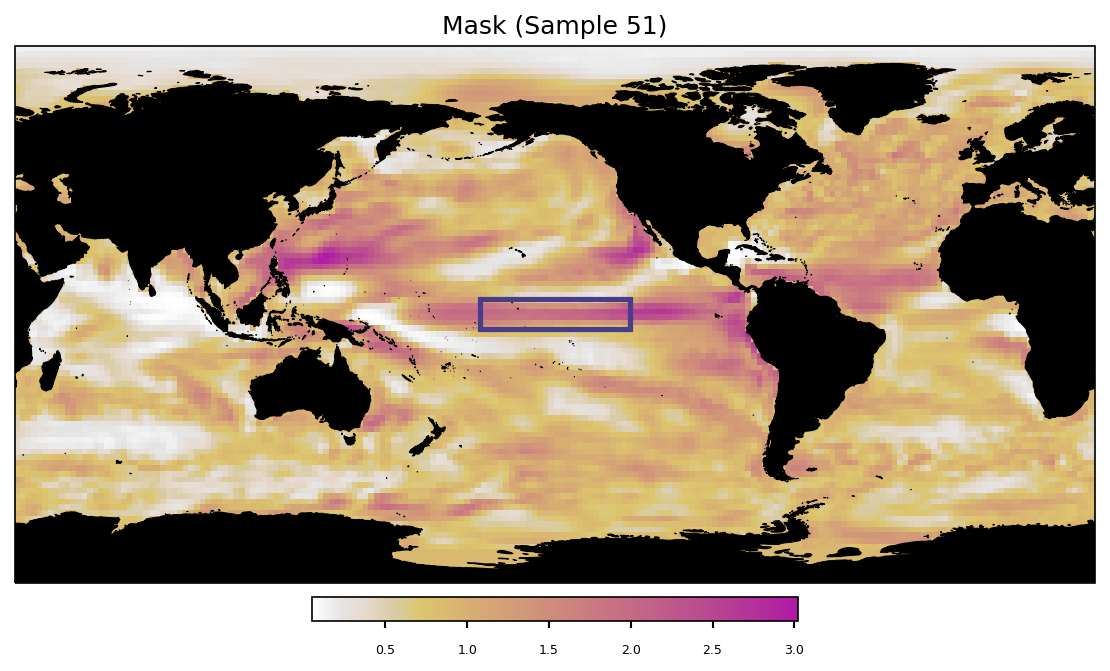

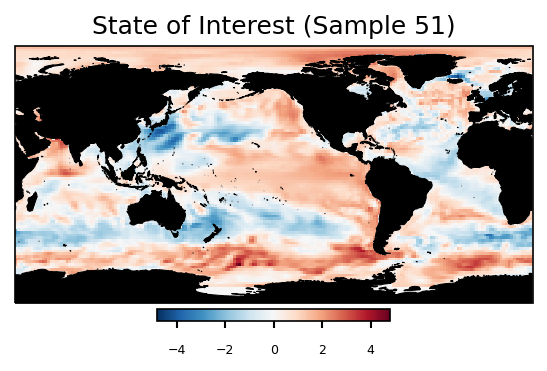

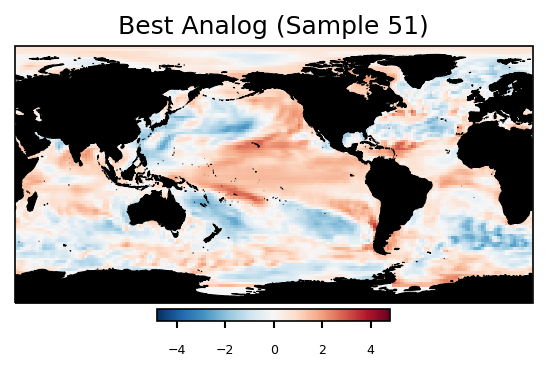

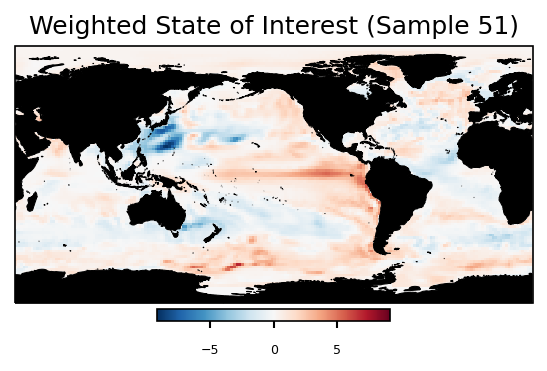

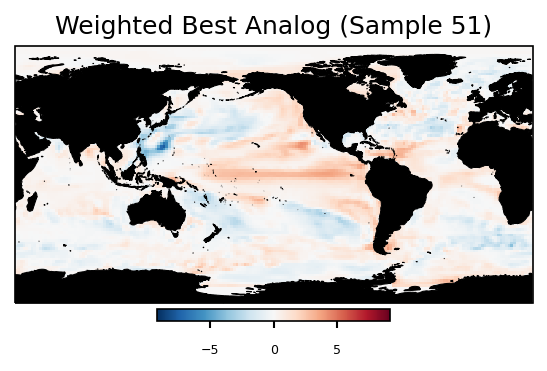

In [92]:
things_to_plot = np.array([mask, soi_map, analog_map, soi_map * mask, analog_map * mask])
titles = np.array(['Mask', 'State of Interest', 'Best Analog', 'Weighted State of Interest', 'Weighted Best Analog'])
plottypes = np.array(['mask', 'input', 'input', 'weighted', 'weighted'])
cmaps = [None, 'RdBu_r', 'RdBu_r', 'RdBu_r', 'RdBu_r']
climitss = []

for plottype in plottypes:
    items_to_climit = np.stack(things_to_plot[plottypes == plottype])
    if plottype == 'mask':
        climitss.append((items_to_climit.min(), items_to_climit.max()))

    else:
        climits_abs = np.abs(items_to_climit).max()
        climitss.append((-climits_abs, climits_abs))

for plotmap, title, climits, cmap, plottype in zip(things_to_plot, titles, climitss, cmaps, plottypes):

    fig_savename = 'map_of_' + title.strip() + '_sample=' + str(sample_num)
    num_maps = plotmap.shape[-1]
    ax = dict()

    if plottype == 'mask':
        fig = plt.figure(figsize=(7.5 * num_maps, 5))
    else:
        fig = plt.figure(figsize=(7.5 * num_maps/2, 5/2))

    # Plotting the region box specs
    edgecolor = 'darkslateblue'
    region_bool = False
    if plottype == 'mask':
        region_bool = True

    for imap in range(num_maps):
        ax, _ = plots.plot_interp_masks(fig, settings, plotmap[..., imap], lat=lat, lon=lon, cmap=cmap,
                                            central_longitude=215., climits = climits, title_text=title + ' (Sample ' + \
                                                str(sample_num) + ')',
                                            subplot=(1, num_maps, imap + 1), use_text=False, 
                                            region_bool=region_bool, edgecolor = edgecolor)

    plt.tight_layout()
    plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

## Investigating Occlusion

In [61]:
# Get the mask
mask = model.get_layer("mask_model").get_layer("weights_layer").bias.numpy().reshape(analog_input[0].shape)
landmask = build_data.maskout_land_ocean(np.ones_like(mask).squeeze(), maskout="land").squeeze()[..., None]
landmask[landmask == 0] = np.nan

soi_input = soi_test_input
soi_output = soi_test_output

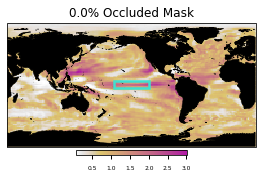

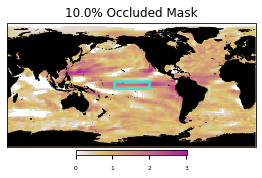

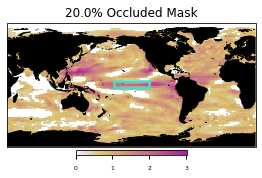

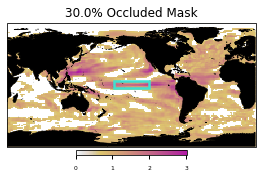

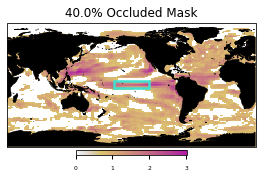

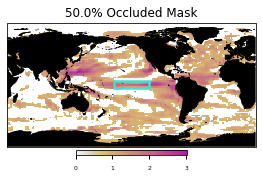

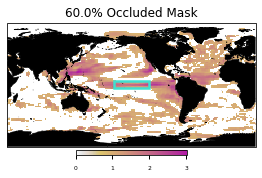

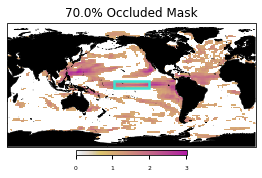

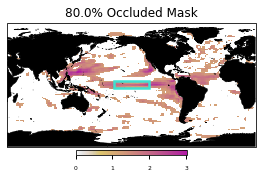

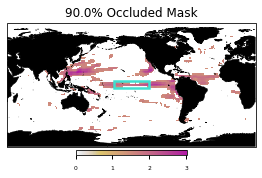

In [65]:
percent_thresholds = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 98, 99, 99.5])
occlusion_error = []

for percent_thresh in percent_thresholds:

    # Occlude the mask
    omask = mask.copy()
    omask [omask < np.nanpercentile(mask * landmask, percent_thresh)] = 0

    # Plot the occluded mask if every 10%
    if percent_thresh % 10 == 0:
        fig_savename = 'occlusionmask_thresh=' + str(percent_thresh)

        num_maps = omask.shape[-1]
        fig = plt.figure(figsize=(7.5 * num_maps/2, 5/2))
        for imap in range(num_maps):
            climits = (omask.min(), omask.max())
            ax, _ = plots.plot_interp_masks(fig, settings, omask[..., imap], lat=lat, lon=lon, cmap=None,
                                                central_longitude=215., climits = climits, title_text= str(percent_thresh) + "% Occluded Mask",
                                                subplot=(1, num_maps, imap + 1), use_text=False)

        plt.tight_layout()
        
        plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                        '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')
    
    # 

    n_processes = 8
    n_analogues = [15,]

    omit_mask_error = np.zeros((soi_input.shape[0], 1)) * np.nan
        
    with Pool(n_processes) as pool:
        soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                                soi_input,
                                                                soi_output,
                                                                analog_input,
                                                                analog_output,
                                                                omask)
        omit_mask_error[:,:]  = model_diagnostics.run_complex_operations(metrics.mse_operation,
                                                        soi_iterable_instance,
                                                        pool,
                                                        chunksize=soi_input.shape[0]//n_processes,)

    occlusion_error.append( metrics.eval_function(omit_mask_error[:,0]) )
    

In [66]:
rng_string = "rng_seed_" + str(settings["rng_seed"])
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
    plot_metrics = pickle.load(f)

error_climo = metrics.eval_function(plot_metrics["error_climo"])

y_plot = 1. - np.array(occlusion_error) / error_climo

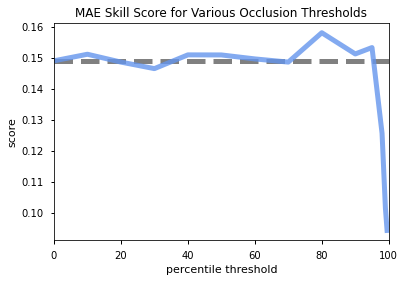

In [68]:
linewidth = 5
alpha = .8

plt.axhline(y_plot[0], zorder=0, color='gray', linestyle='dashed', alpha=1, linewidth=linewidth)
plt.plot(percent_thresholds, y_plot, label='Truth', color='cornflowerblue', linewidth=linewidth, alpha=alpha)

plt.ylabel('score')
plt.xlabel('percentile threshold')
plt.xlim(0, 100)
#plt.xticks(np.arange(10,50,10))
#plt.yticks([-2, 0, 2])

#plt.ylim(-.4, .4)
plt.grid(False)

plt.title('MAE Skill Score for Various Occlusion Thresholds')
#plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
#                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

## Exploring region-by-region occlusion

In [438]:
# Get the mask
mask = model.get_layer("mask_model").get_layer("weights_layer").bias.numpy().reshape(analog_input[0].shape)
landmask = build_data.maskout_land_ocean(np.ones_like(mask).squeeze(), maskout="land").squeeze()[..., None]
landmask[landmask == 0] = np.nan

soi_input = soi_test_input
soi_output = soi_test_output

percent_thresh = 95

# Define regions
reg1=[(100, 0), (70, 40)] # Bottom left corner (lon, lat) and length (lon, lat)
reg2=[(170, -25), (125, 35)]
reg3=[(220, 10), (30, 30)]
reg4=[(280, 0), (60, 20)]

regions_rect = [reg1, reg2, reg3, reg4]
regions = [((reg[0][1], reg[0][1]+reg[1][1]),
            (reg[0][0], reg[0][0]+reg[1][0]),) for reg in regions_rect]

def get_regions_mask(regions):
    region_mask = np.zeros_like(landmask)
    for reg in regions:
        region_mask_lat = np.zeros_like(region_mask)
        region_mask_lon = np.zeros_like(region_mask)
        region_mask_lat[np.logical_and(lat > reg[0][0], lat < reg[0][1]), ...] = 1
        region_mask_lon[:, np.logical_and(lon > reg[1][0], lon < reg[1][1]), ...] = 1
        region_mask = region_mask + region_mask_lat*region_mask_lon
    return region_mask

region_mask = get_regions_mask(regions)

omask = mask.copy()
omask[omask < np.nanpercentile(mask * landmask, percent_thresh)] = 0
#omask = omask * region_mask

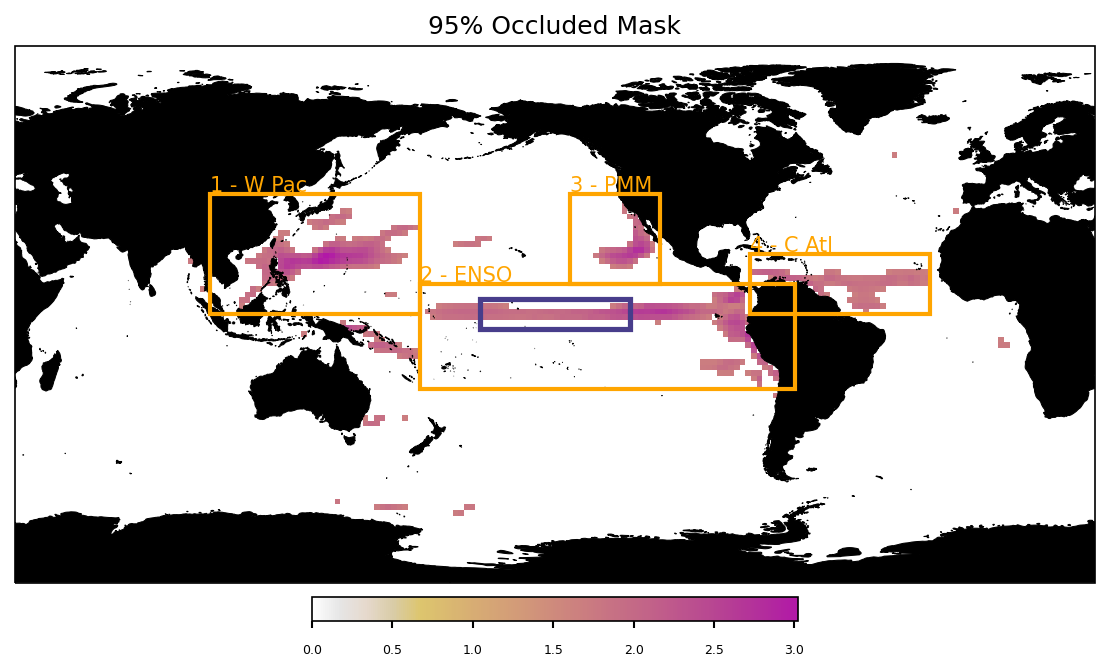

In [440]:
add_boxes = True
fig_savename = 'occluded_mask_regionboxes=' + str(add_boxes)
num_maps = omask.shape[-1]
fig = plt.figure(figsize=(7.5 * num_maps, 5))
for imap in range(num_maps):
    climits = (omask.min(), omask.max())
    ax, _ = plots.plot_interp_masks(fig, settings, omask[..., imap], lat=lat, lon=lon, cmap=None,
                                        central_longitude=215., climits = climits, title_text= str(percent_thresh) + "% Occluded Mask",
                                        subplot=(1, num_maps, imap + 1), use_text=False, edgecolor='darkslateblue',
                                        region_bool=add_boxes)
    
    if add_boxes:
        rects = dict()
        extra_string = ['W Pac', 'ENSO', 'PMM', 'C Atl']
        for ireg, reg in enumerate(regions_rect):
            rects[ireg] = matplotlib.patches.Rectangle(reg[0], reg[1][0], reg[1][1], facecolor='none', edgecolor = 'orange', 
                                            linewidth=2, transform=ccrs.PlateCarree(), zorder=10)

            ax.add_patch(rects[ireg])
            ax.text(reg[0][0], reg[0][1] + reg[1][1] + 1, str(ireg + 1) + ' - ' + extra_string[ireg], transform=ccrs.PlateCarree(), color='orange')
        
        

plt.tight_layout()
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                        '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')


#### Exclude each region and then do predictions.

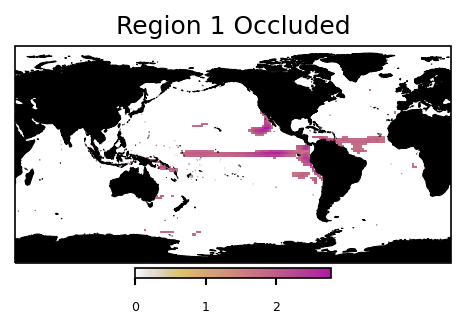

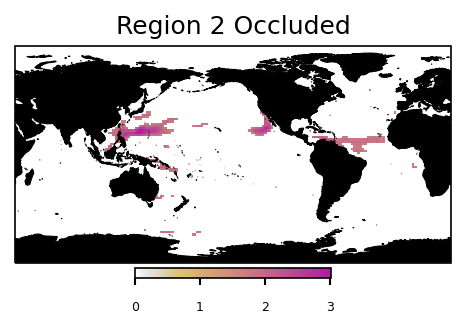

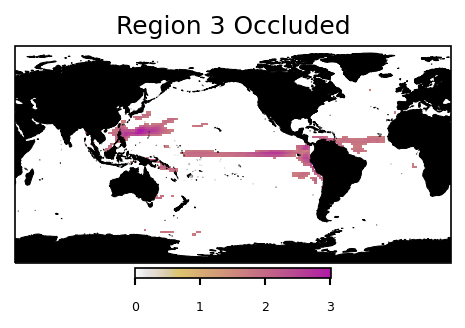

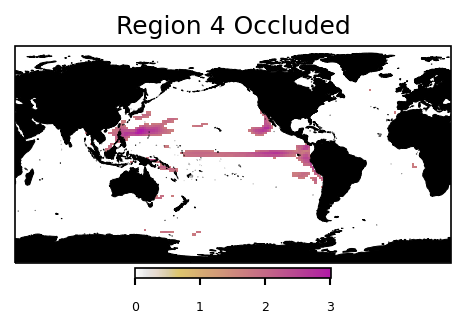

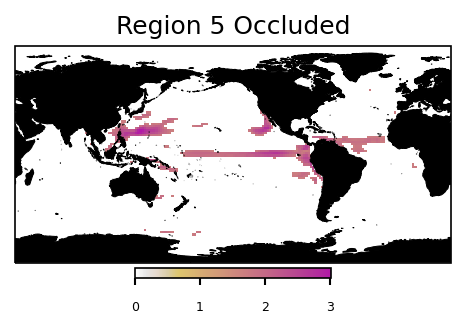

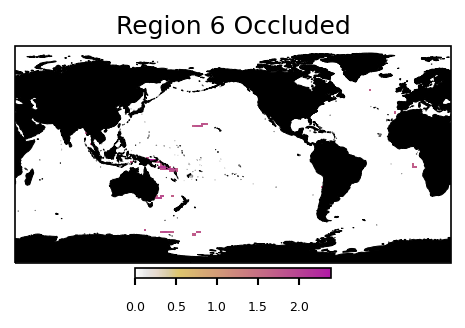

In [441]:
region_occlusion_error = []
masked_occlusion_weight_sum = []

for i in range(len(regions) + 2):
    this_regions = regions.copy()
    if i < len(regions):
        this_regions = [this_regions[i]]
    elif i == len(regions):
        this_regions = []
    # else keep everything for this_regions == len +1

    region_mask = get_regions_mask(this_regions)
    region_mask = (region_mask - 1) * -1

    # Adjust the mask
    omask = mask.copy()
    omask[omask < np.nanpercentile(mask * landmask, percent_thresh)] = 0
    omask = omask * region_mask

    masked_occlusion_weight_sum.append(np.sum(omask))

    num_maps = omask.shape[-1]
    fig = plt.figure(figsize=(7.5 * num_maps/2, 5/2))
    for imap in range(num_maps):
        climits = (omask.min(), omask.max())
        ax, _ = plots.plot_interp_masks(fig, settings, omask[..., imap], lat=lat, lon=lon, cmap=None,
                                            central_longitude=215., climits = climits, title_text= "Region " + str(i+1) + " Occluded",
                                            subplot=(1, num_maps, imap + 1), use_text=False, region_bool=False)
    fig_savename = 'discludedmask_reg=' + str(i+1)
    plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                        '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')
    plt.show()

    ### DO THE PERFORMANCE CALCULATIONS

    n_processes = 8
    n_analogues = [15,]

    omit_mask_error = np.zeros((soi_input.shape[0], 1)) * np.nan
        
    with Pool(n_processes) as pool:
        soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                                soi_input,
                                                                soi_output,
                                                                analog_input,
                                                                analog_output,
                                                                omask)
        omit_mask_error[:,:]  = model_diagnostics.run_complex_operations(metrics.mse_operation,
                                                        soi_iterable_instance,
                                                        pool,
                                                        chunksize=soi_input.shape[0]//n_processes,)

    region_occlusion_error.append( metrics.eval_function(omit_mask_error[:,0]) )

In [399]:
rng_string = "rng_seed_" + str(settings["rng_seed"])
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
    plot_metrics = pickle.load(f)

error_climo = metrics.eval_function(plot_metrics["error_climo"])

y_plot = 1. - np.array(region_occlusion_error) / error_climo

Text(0.5, 1.0, 'MAE Skill Score for Regional Occlusions')

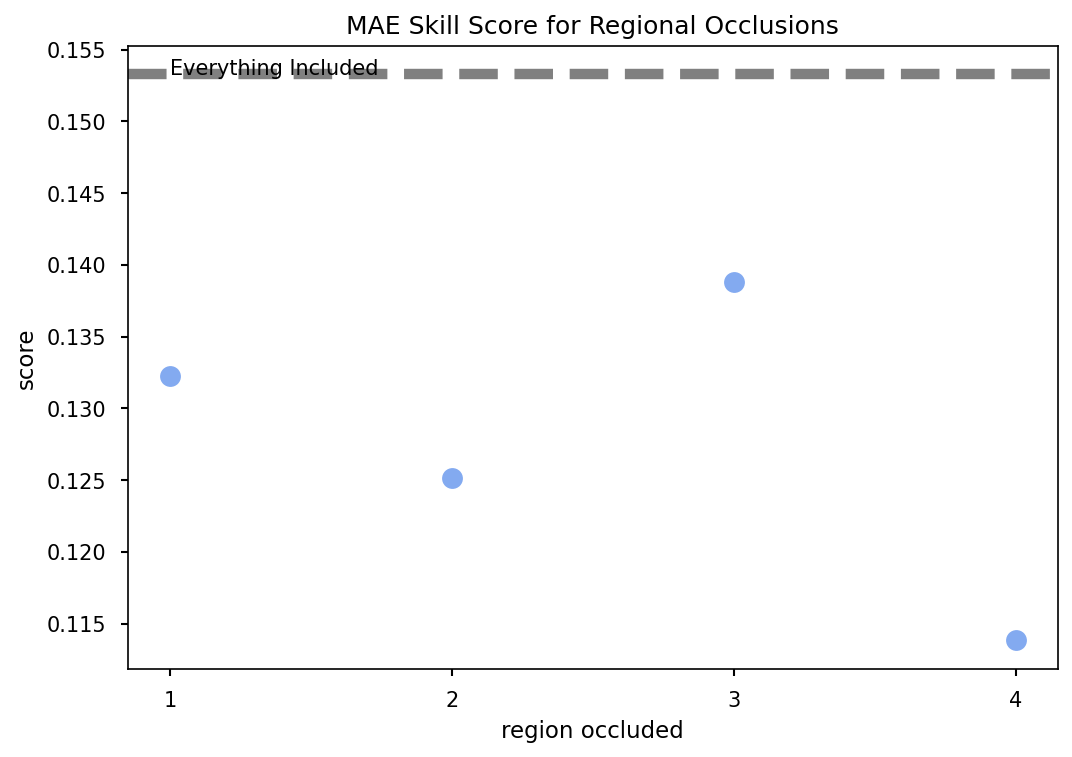

In [405]:
linewidth = 5
markersize = 10
alpha = .8

plt.figure()
plt.axhline(y_plot[-2], zorder=0, color='gray', linestyle='dashed', alpha=1, linewidth=linewidth)
plt.text(1, y_plot[-2], 'Everything Included')
#plt.axhline(y_plot[-1], zorder=0, color='gray', linestyle='dashed', alpha=1, linewidth=linewidth)
#plt.text(1, y_plot[-1], 'All Regions Discluded')
plt.plot([1,2,3,4], y_plot[:-2], 'o', label='Truth', color='cornflowerblue', markersize=markersize, alpha=alpha)

plt.ylabel('score')
plt.xlabel('region occluded')
plt.xticks([1,2,3,4])

plt.grid(False)

plt.title('MAE Skill Score for Regional Occlusions')
#plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
#                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

In [401]:
# plt.figure(figsize=(4,2))
# plt.plot(masked_occlusion_weight_sum[:], y_plot[:], 'o', label='Truth', color='cornflowerblue', markersize=markersize, alpha=alpha)

# for i, xloc, yloc in zip(range(len(y_plot)), masked_occlusion_weight_sum[:], y_plot[:]):
#     plt.text(xloc, yloc, str(i + 1), size=15)

# plt.xlabel('sum of included weights')
# plt.ylabel('score')

#### Include each region and then do predictions.

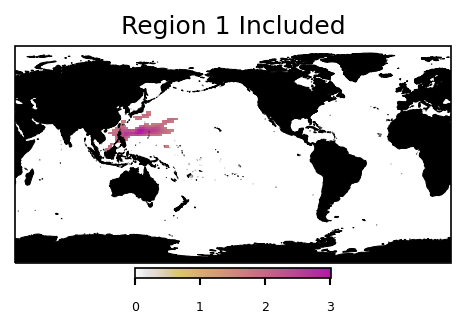

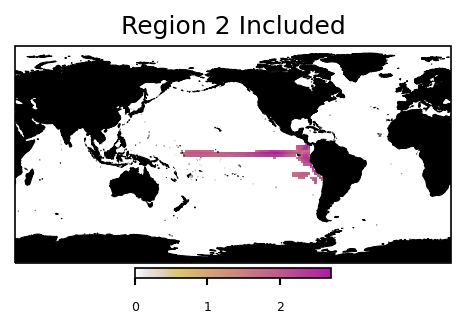

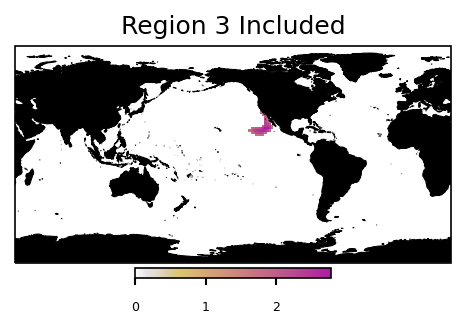

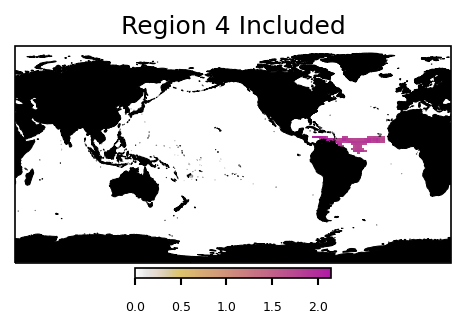

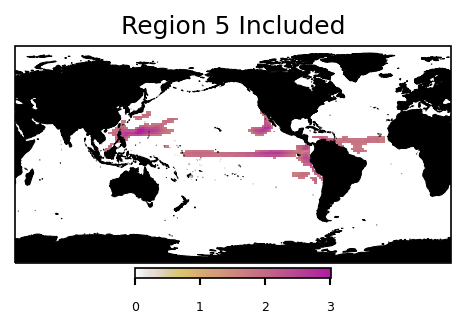

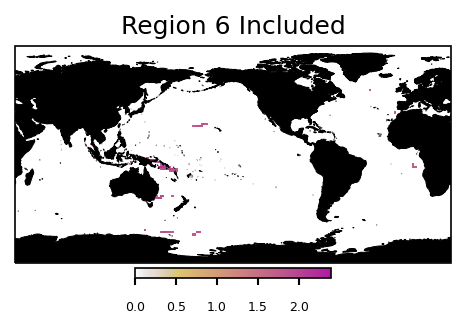

In [443]:
region_inclusion_error = []
masked_inclusion_weight_sum = []

for i in range(len(regions) + 2):
    if i < len(regions):
        this_regions = regions[i:i+1]
    else:
        this_regions = regions
    region_mask = get_regions_mask(this_regions)

    if i == len(regions) + 1:
        region_mask = (region_mask - 1) * -1

    omask = mask.copy()
    omask[omask < np.nanpercentile(mask * landmask, percent_thresh)] = 0
    omask = omask * region_mask

    masked_inclusion_weight_sum.append(np.sum(omask))

    num_maps = omask.shape[-1]
    fig = plt.figure(figsize=(7.5 * num_maps/2, 5/2))
    for imap in range(num_maps):
        climits = (omask.min(), omask.max())
        ax, _ = plots.plot_interp_masks(fig, settings, omask[..., imap], lat=lat, lon=lon, cmap=None,
                                            central_longitude=215., climits = climits, 
                                            title_text= "Region " + str(i+1) + " Included",
                                            subplot=(1, num_maps, imap + 1), use_text=False, region_bool=False)
    fig_savename = 'includedmask_reg=' + str(i+1)
    plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                        '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')
    plt.show()

    ### DO THE PERFORMANCE CALCULATIONS

    n_processes = 8
    n_analogues = [15,]

    omit_mask_error = np.zeros((soi_input.shape[0], 1)) * np.nan
        
    with Pool(n_processes) as pool:
        soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                                soi_input,
                                                                soi_output,
                                                                analog_input,
                                                                analog_output,
                                                                omask)
        omit_mask_error[:,:]  = model_diagnostics.run_complex_operations(metrics.mse_operation,
                                                        soi_iterable_instance,
                                                        pool,
                                                        chunksize=soi_input.shape[0]//n_processes,)

    region_inclusion_error.append( metrics.eval_function(omit_mask_error[:,0]) )

In [407]:
prev_yplot = y_plot.copy()

rng_string = "rng_seed_" + str(settings["rng_seed"])
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
    plot_metrics = pickle.load(f)

error_climo = metrics.eval_function(plot_metrics["error_climo"])

y_plot = 1. - np.array(region_inclusion_error) / error_climo

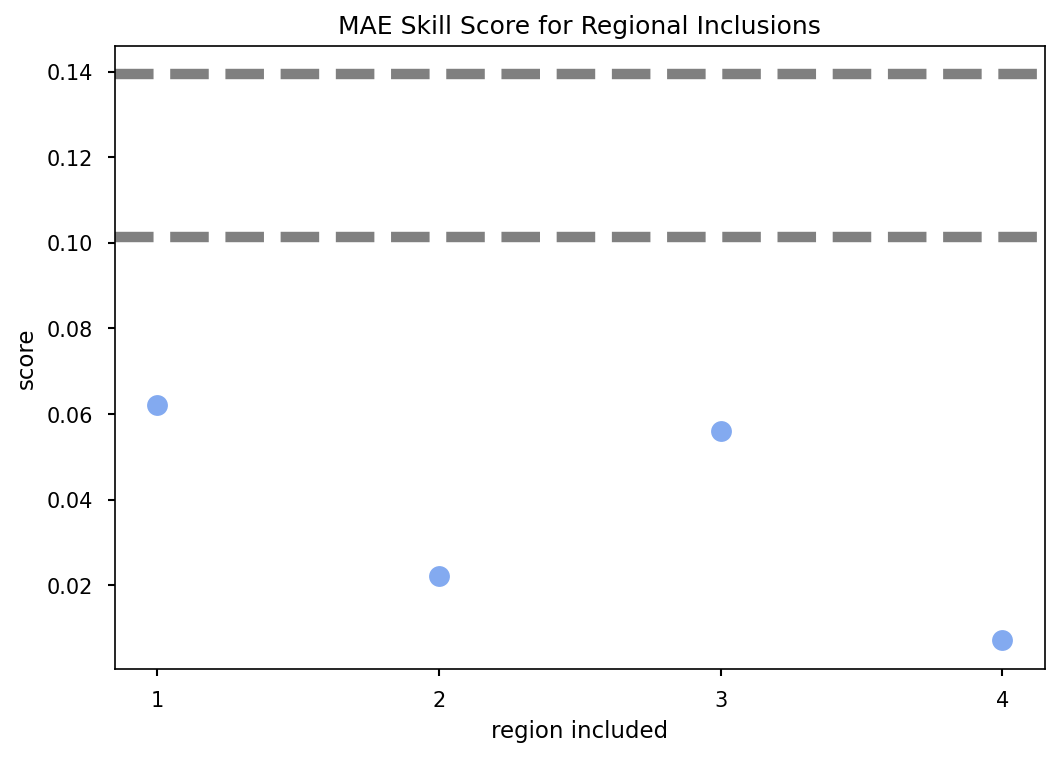

In [331]:
linewidth = 5
markersize = 10
alpha = .8

plt.axhline(y_plot[-2], zorder=0, color='gray', linestyle='dashed', alpha=1, linewidth=linewidth)
plt.axhline(y_plot[-1], zorder=0, color='gray', linestyle='dashed', alpha=1, linewidth=linewidth)
plt.plot([1,2,3,4], y_plot[:-2], 'o', label='Truth', color='cornflowerblue', markersize=markersize, alpha=alpha)

plt.ylabel('score')
plt.xlabel('region included')
plt.xticks([1,2,3,4])

plt.grid(False)

plt.title('MAE Skill Score for Regional Inclusions')
plt.show()
#plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
#                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

In [408]:
# plt.plot(masked_inclusion_weight_sum, y_plot, 'o', label='Truth', color='cornflowerblue', markersize=markersize, alpha=alpha)
# plt.xlabel('sum of included weights')
# plt.ylabel('score')

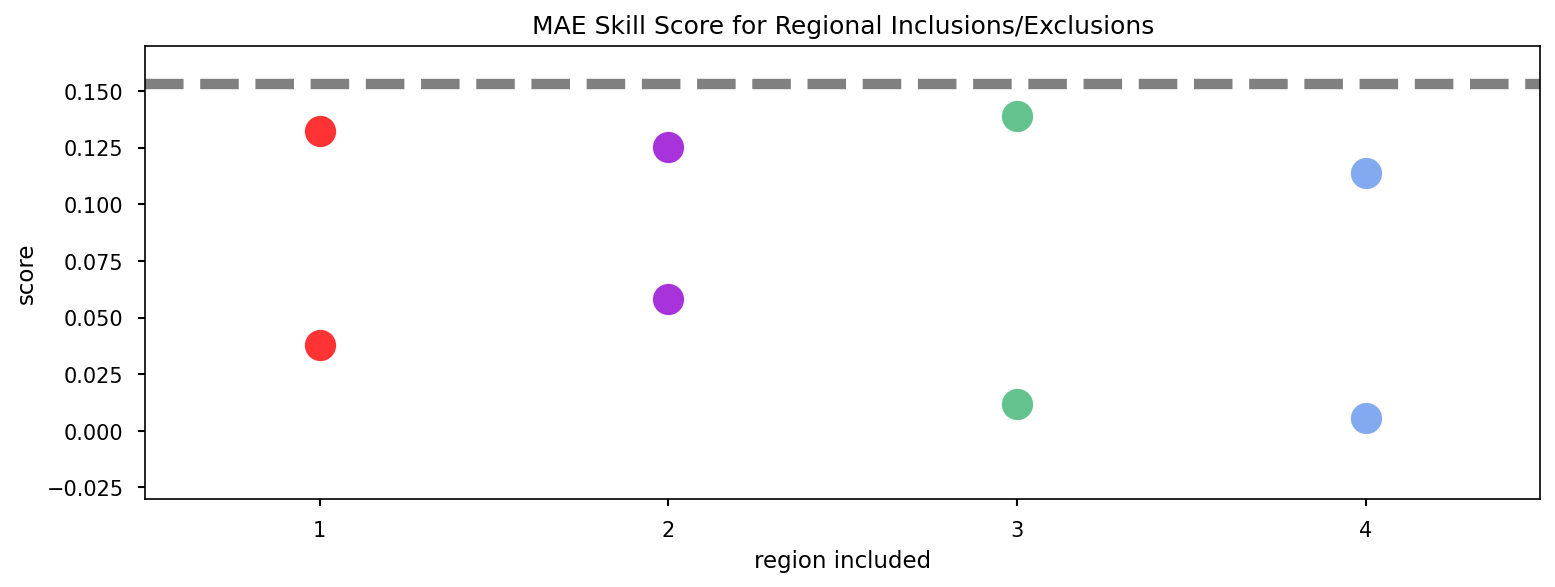

In [446]:
linewidth = 5
markersize = 15
alpha = .8

colors = ['red', 'darkviolet', 'mediumseagreen', 'cornflowerblue']

plt.figure(figsize=(12, 4))
plt.axhline(prev_yplot[-2], zorder=0, color='gray', linestyle='dashed', alpha=1, linewidth=linewidth)

for i, c in zip(range(4), colors):
    plt.plot([i+1], prev_yplot[i], 'o', label='Excluded', color=c, markersize=markersize, alpha=alpha)
    plt.plot([i+1], y_plot[i], 'o', label='Included', color=c, markersize=markersize, alpha=alpha)

plt.ylabel('score')
plt.xlabel('region included')
plt.xticks([1,2,3,4])
plt.xlim(.5, 4.5)
plt.ylim(-.03, .17)

plt.grid(False)

plt.title('MAE Skill Score for Regional Inclusions/Exclusions')

fig_savename = 'exclusion_inclusion_scores'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

plt.show()

# Making Figure 5: North Atlantic SST Map + Performance

In [93]:
exp_name = 'exp500'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()


In [94]:
settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp500.pickle
   analog data
 # analog samples = 5145
   training data
 # soi samples = 2205
   validation data
   # soi samples = 735
   testing data
  # soi samples = 735



In [95]:
# Get the mask
mask = model.get_layer("mask_model").get_layer("weights_layer").bias.numpy().reshape(analog_input[0].shape)

In [96]:
imp.reload(metrics)

n_processes = 8
n_analogues = 15
soi_input = soi_test_input
soi_output = soi_test_output

[[0.24149209]]


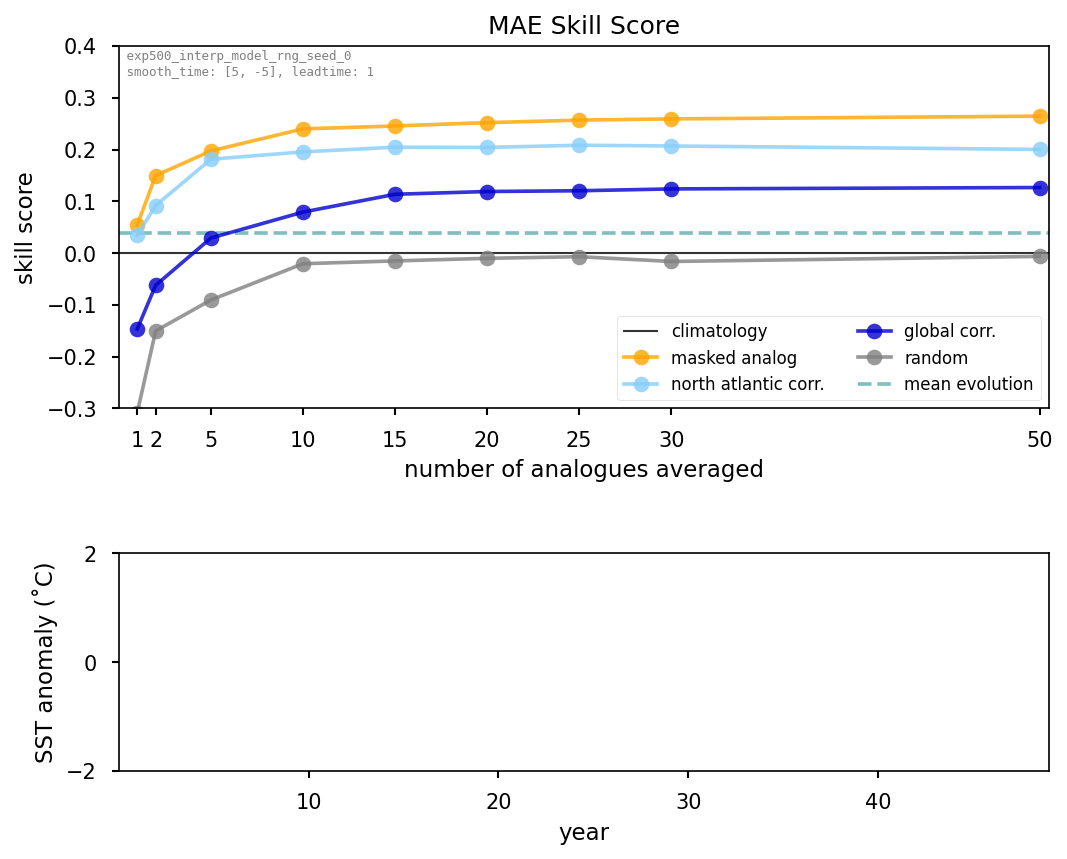

In [97]:
# MAKE SUMMARY PLOT ACROSS ALL MODEL TYPES
rng_string = settings["savename_prefix"][settings["savename_prefix"].find('rng'):]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4 * 1.6), gridspec_kw={'height_ratios': [5, 3], 'hspace' : .5})
i_rng, rng_string = 0, "rng_seed_0"

# GET THE METRICS DATA
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
    plot_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_analog_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_analog_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_metrics = pickle.load(f)

# PLOT THE METRICS
sub = plt.subplot(2, 1, 1)

n_analogs_list = np.array([1, 2, 5, 10, 15, 20, 25, 30, 50])
i_n_analogs = np.argwhere(n_analogs_list == n_analogues)

plots.summarize_skill_score(plot_metrics)

plot_ann_metrics = ann_analog_metrics
y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_network"][i_n_analogs]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
print(y_plot)
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.8, label="ann analog")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_persist"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.2, label="persistence")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_custom"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.5, label="custom")

plt.text(0.0, .99, ' ' + settings["exp_name"] + "_interp_model_" + rng_string + '\n smooth_time: ['
            + str(settings["smooth_len_input"]) + ', ' + str(settings["smooth_len_output"]) + '], leadtime: '
            + str(settings["lead_time"]),
            fontsize=6, color="gray", va="top", ha="left", fontfamily="monospace",
            transform=plt.gca().transAxes)
plt.grid(False)
plt.ylim(-.3, .4)

# Remove some lines
lines = sub.get_lines()
for line in [3, 6, 7]:
    lines[line].remove()

# Update some line labels
lines[0].set_label('climatology')
lines[2].set_label('north atlantic corr.')
lines[8].set_label('mean evolution')

# Change a color
#lines[2].set_color('deepskyblue')
#lines[3].set_color('mediumblue')
#lines[8].set_color('lightgray')
#lines[8].set_alpha(1)

# Change order
lines[8].set_zorder(0)

plt.legend(fontsize=8, loc=4, ncol=2)
plt.xticks(n_analogs_list)

# This stuff just keeps the second subplot the exact same as in Figure 3
plt.subplot(2, 1, 2)

plt.ylabel('SST anomaly (˚C)')
plt.xlabel('year')
plt.xlim(0, 49)
plt.xticks(np.arange(10,50,10))
plt.yticks([-2, 0, 2])

fig_savename = 'Figure5b_alt'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

^ Note, keeping two panels here so it has the same shape as the one in the first part of the paper.

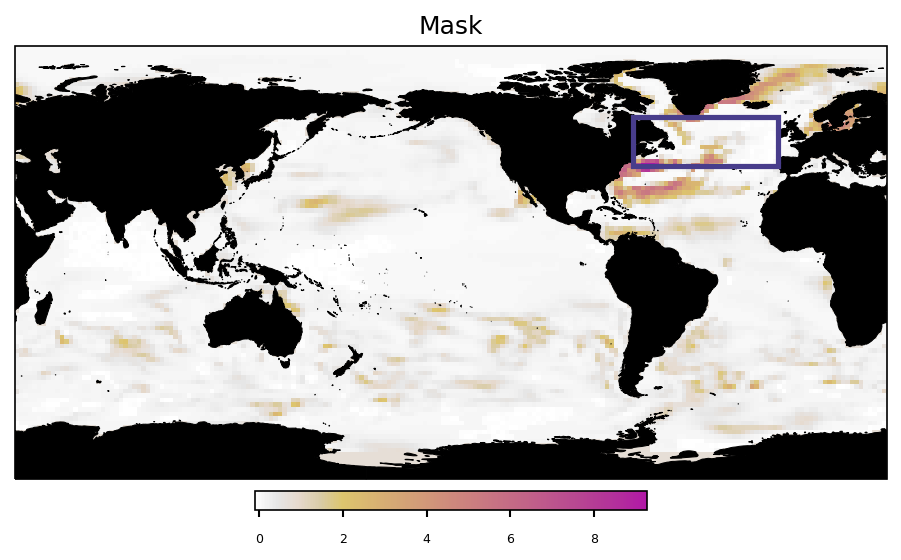

In [98]:
ax = dict()

fig = plt.figure(figsize=(7.5 * 1, 5))

# Plotting the region box specs
edgecolor = 'darkslateblue'
region_bool = True
climits = [mask.min(), mask.max()]
ax, _ = plots.plot_interp_masks(fig, settings, mask[..., 0], lat=lat, lon=lon, cmap=None,
                                    central_longitude=215., climits = climits, title_text="Mask",
                                    subplot=(1, 1, 1), use_text=False, 
                                    region_bool=region_bool, edgecolor = edgecolor)

fig_savename = 'Figure5a_alt'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

# CUSTOM PLOTS IF NORTH ATLANTIC IS MAIN EXAMPLE

In [15]:
exp_name = 'exp500'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()
settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])
# Get the mask
mask = model.get_layer("mask_model").get_layer("weights_layer").bias.numpy().reshape(analog_input[0].shape)
imp.reload(metrics)

n_processes = 8
n_analogues = 15
soi_input = soi_test_input
soi_output = soi_test_output

predictions = np.zeros((3, soi_input.shape[0])).T * np.nan

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    predictions[:,:]  = model_diagnostics.run_complex_operations(metrics.test_predictions,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp500.pickle
   analog data
 # analog samples = 5145
   training data
 # soi samples = 2205
   validation data
   # soi samples = 735
   testing data
  # soi samples = 735



[[0.24149209]]


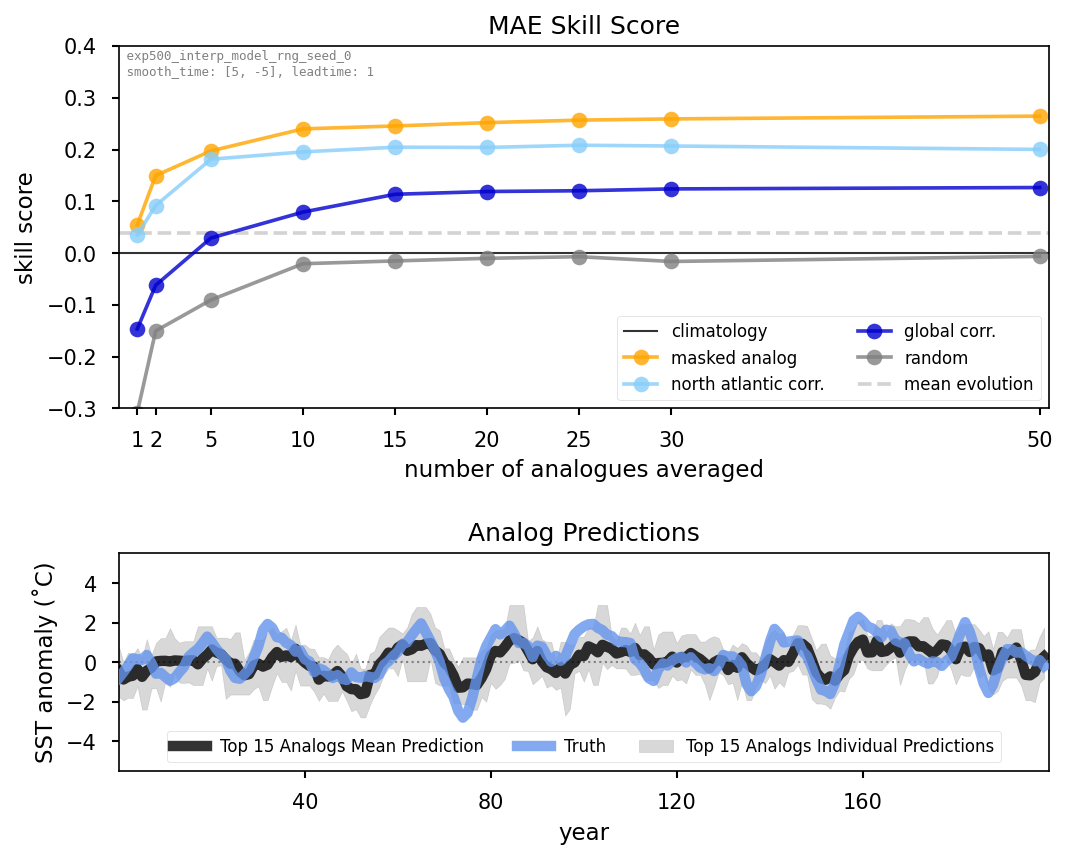

In [20]:
# MAKE SUMMARY PLOT ACROSS ALL MODEL TYPES
rng_string = settings["savename_prefix"][settings["savename_prefix"].find('rng'):]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4 * 1.6), gridspec_kw={'height_ratios': [5, 3], 'hspace' : .5})
i_rng, rng_string = 0, "rng_seed_0"

# GET THE METRICS DATA
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
    plot_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_analog_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_analog_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_metrics = pickle.load(f)

# PLOT THE METRICS
sub = plt.subplot(2, 1, 1)

n_analogs_list = np.array([1, 2, 5, 10, 15, 20, 25, 30, 50])
i_n_analogs = np.argwhere(n_analogs_list == n_analogues)

plots.summarize_skill_score(plot_metrics)

plot_ann_metrics = ann_analog_metrics
y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_network"][i_n_analogs]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
print(y_plot)
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.8, label="ann analog")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_persist"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.2, label="persistence")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_custom"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.5, label="custom")

plt.text(0.0, .99, ' ' + settings["exp_name"] + "_interp_model_" + rng_string + '\n smooth_time: ['
            + str(settings["smooth_len_input"]) + ', ' + str(settings["smooth_len_output"]) + '], leadtime: '
            + str(settings["lead_time"]),
            fontsize=6, color="gray", va="top", ha="left", fontfamily="monospace",
            transform=plt.gca().transAxes)
plt.grid(False)
plt.ylim(-.3, .4)

# Remove some lines
lines = sub.get_lines()
for line in [3, 6, 7]:
    lines[line].remove()

# Update some line labels
lines[0].set_label('climatology')
lines[2].set_label('north atlantic corr.')
lines[8].set_label('mean evolution')

# Change a color
#lines[2].set_color('deepskyblue')
#lines[3].set_color('mediumblue')
lines[8].set_color('lightgray')
lines[8].set_alpha(1)

# Change order
lines[8].set_zorder(0)

plt.legend(fontsize=8, loc=4, ncol=2)
plt.xticks(n_analogs_list)

###
### PREDICTIONS PART
###

plt.subplot(2, 1, 2)

start_year = 150
num_years = 200
end_year = start_year + num_years
analog_vals = predictions[start_year:end_year,0]
analog_mins = predictions[start_year:end_year,1]
analog_maxs = predictions[start_year:end_year,2]
truth_vals = soi_output[start_year:end_year]
#plt.figure(figsize=(8, 2.5))

linewidth = 5
alpha = .8

plt.axhline(0, zorder=0, color='gray', linestyle='dotted', alpha=1, linewidth=1)
plt.plot(analog_vals, label='Top 15 Analogs Mean Prediction', color='k', linewidth=linewidth, alpha=alpha, zorder=2)
plt.plot(truth_vals, label='Truth', color='cornflowerblue', linewidth=linewidth, alpha=alpha, zorder=3)
plt.fill_between(range(len(analog_mins)), analog_mins, analog_maxs, color='gray', alpha = .3, zorder=1,
                 label='Top 15 Analogs Individual Predictions')

plt.ylabel('SST anomaly (˚C)')
plt.xlabel('year')
plt.xlim(0, num_years)
plt.xticks(np.arange(num_years//5,num_years,num_years//5))
plt.yticks([-4, -2, 0, 2, 4])

plt.ylim(-5.5, 5.5)
plt.grid(False)
plt.legend(fontsize=8, ncol=3, loc="lower center",)
plt.title('Analog Predictions')

fig_savename = 'Figure3'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

In [ ]:
## Plot the Mask, plus the Mask times Input and Best Analog (Figure 2)
imp.reload(metrics)
imp.reload(plots)

# Get the mask
mask = model.get_layer("mask_model").get_layer("weights_layer").bias.numpy().reshape(analog_input[0].shape)
n_processes = 8
n_analogues = 15
soi_input = soi_test_input
soi_output = soi_test_output

best_analog_maps = np.zeros(soi_input.shape) * np.nan

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    best_analog_maps  = model_diagnostics.run_complex_operations(metrics.get_best_analog,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)
sample_num = 223
analog_map = best_analog_maps[sample_num]
soi_map = soi_input[sample_num]
things_to_plot = np.array([mask, soi_map, analog_map, soi_map * mask, analog_map * mask])
titles = np.array(['Mask', 'State of Interest', 'Best Analog', 'Weighted State of Interest', 'Weighted Best Analog'])
plottypes = np.array(['mask', 'input', 'input', 'weighted', 'weighted'])
cmaps = [None, 'RdBu_r', 'RdBu_r', 'RdBu_r', 'RdBu_r']
climitss = []

for plottype in plottypes:
    items_to_climit = np.stack(things_to_plot[plottypes == plottype])
    if plottype == 'mask':
        climitss.append((items_to_climit.min(), items_to_climit.max()))

    else:
        climits_abs = np.abs(items_to_climit).max()
        climitss.append((-climits_abs, climits_abs))

for plotmap, title, climits, cmap, plottype in zip(things_to_plot, titles, climitss, cmaps, plottypes):

    fig_savename = 'map_of_' + title.strip() + '_sample=' + str(sample_num)
    num_maps = plotmap.shape[-1]
    ax = dict()

    if plottype == 'mask':
        fig = plt.figure(figsize=(7.5 * num_maps, 5))
    else:
        fig = plt.figure(figsize=(7.5 * num_maps/2, 5/2))

    # Plotting the region box specs
    edgecolor = 'darkslateblue'
    region_bool = False
    if plottype == 'mask':
        region_bool = True

    for imap in range(num_maps):
        ax, _ = plots.plot_interp_masks(fig, settings, plotmap[..., imap], lat=lat, lon=lon, cmap=cmap,
                                            central_longitude=215., climits = climits, title_text=title + ' (Sample ' + \
                                                str(sample_num) + ')',
                                            subplot=(1, num_maps, imap + 1), use_text=False, 
                                            region_bool=region_bool, edgecolor = edgecolor)

    plt.tight_layout()
    # plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
    #                 '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

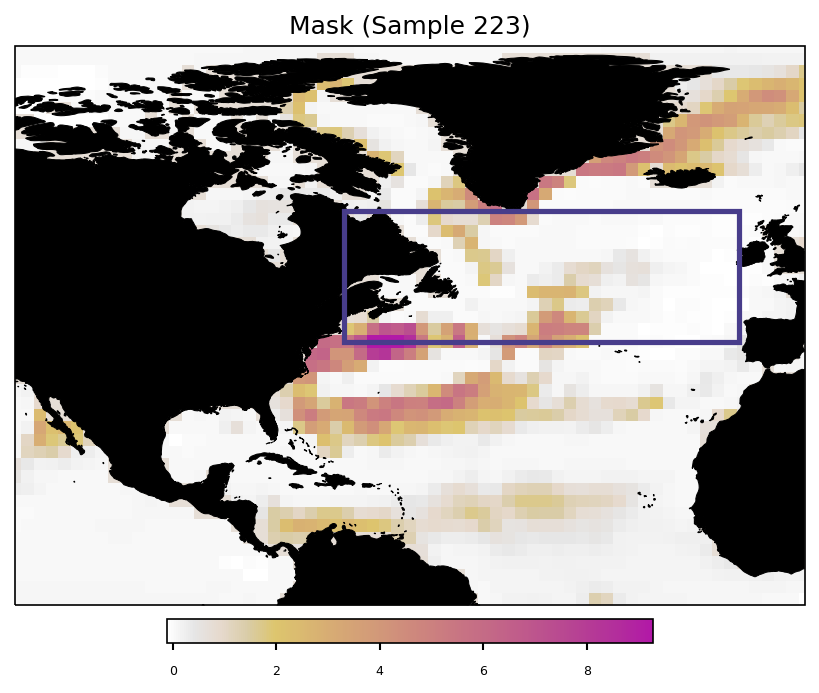

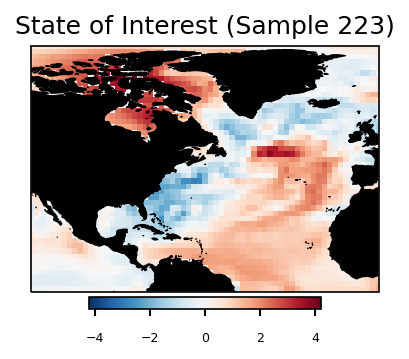

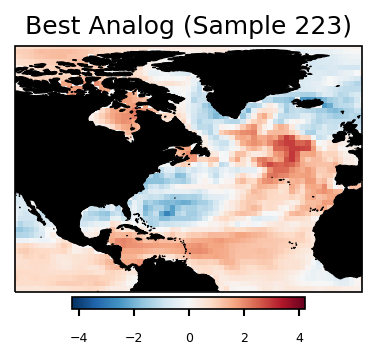

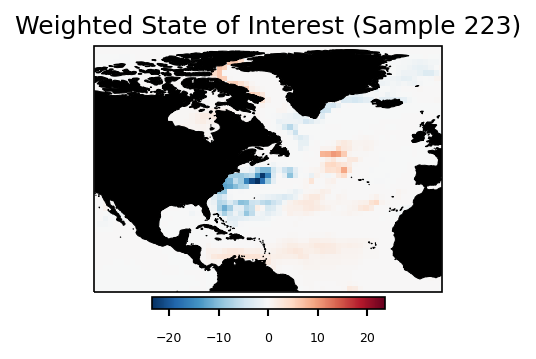

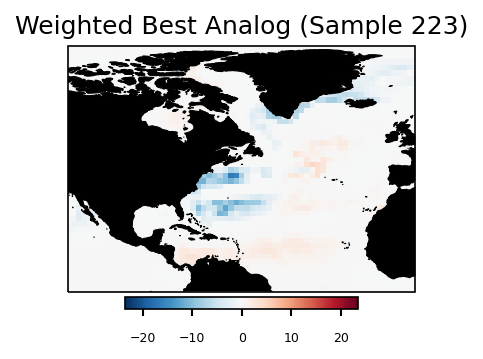

In [7]:
### ZOOMED IN ON THE IMPORTANT REGIONS
for plotmap, title, climits, cmap, plottype in zip(things_to_plot, titles, climitss, cmaps, plottypes):

    fig_savename = 'zoomedmap_of_' + title.strip() + '_sample=' + str(sample_num)
    num_maps = plotmap.shape[-1]
    ax = dict()

    if plottype == 'mask':
        fig = plt.figure(figsize=(7.5 * num_maps, 5))
    else:
        fig = plt.figure(figsize=(7.5 * num_maps/2, 5/2))

    # Plotting the region box specs
    edgecolor = 'darkslateblue'
    region_bool = False
    if plottype == 'mask':
        region_bool = True

    for imap in range(num_maps):
        ax, _ = plots.plot_interp_masks(fig, settings, plotmap[..., imap], lat=lat, lon=lon, cmap=cmap,
                                            central_longitude=215., climits = climits, title_text=title + ' (Sample ' + \
                                                str(sample_num) + ')',
                                            subplot=(1, num_maps, imap + 1), use_text=False, 
                                            region_bool=region_bool, edgecolor = edgecolor)
        ax.set_extent([240, 360, 0, 80])
    
    #plt.xlim(240, 360)
    #plt.ylim(0, 90)
    plt.tight_layout()
    plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

Figure 4 (equivalent of Figure 5_alt)

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp300.pickle
   analog data
 # analog samples = 5390
   training data
 # soi samples = 2310
   validation data
   # soi samples = 770
   testing data
  # soi samples = 770

[[0.1597199]]


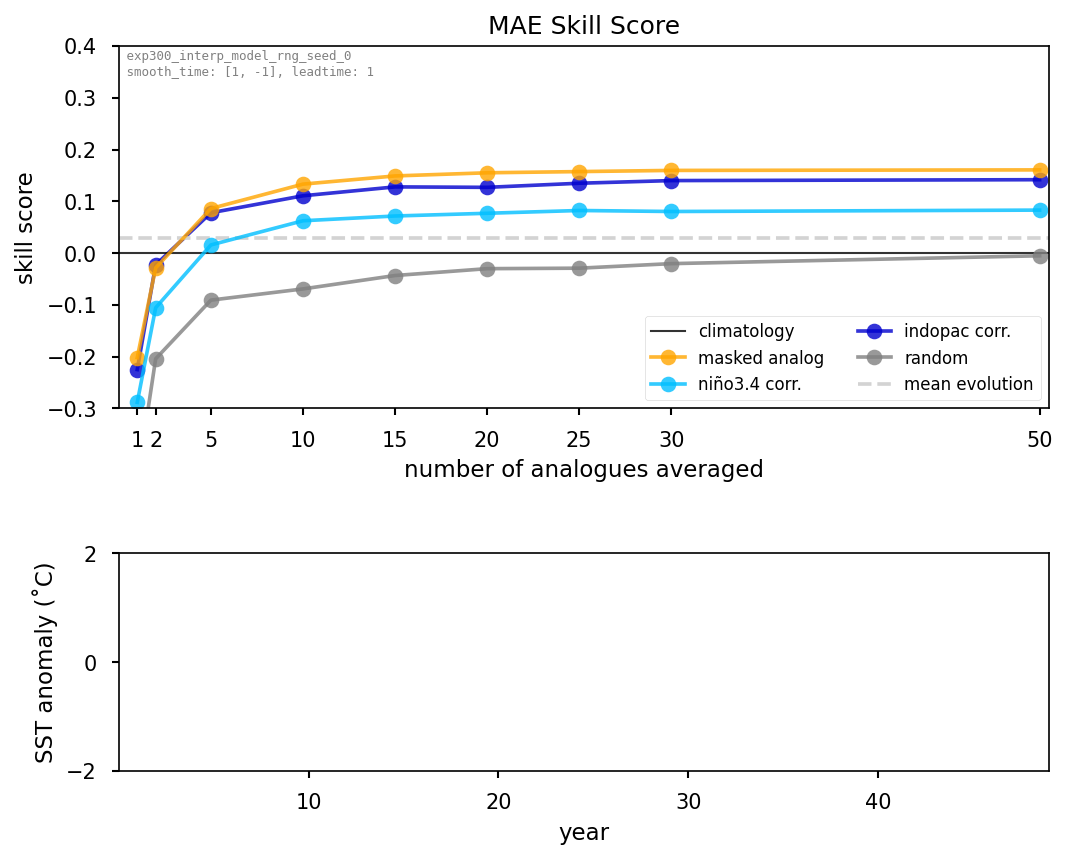

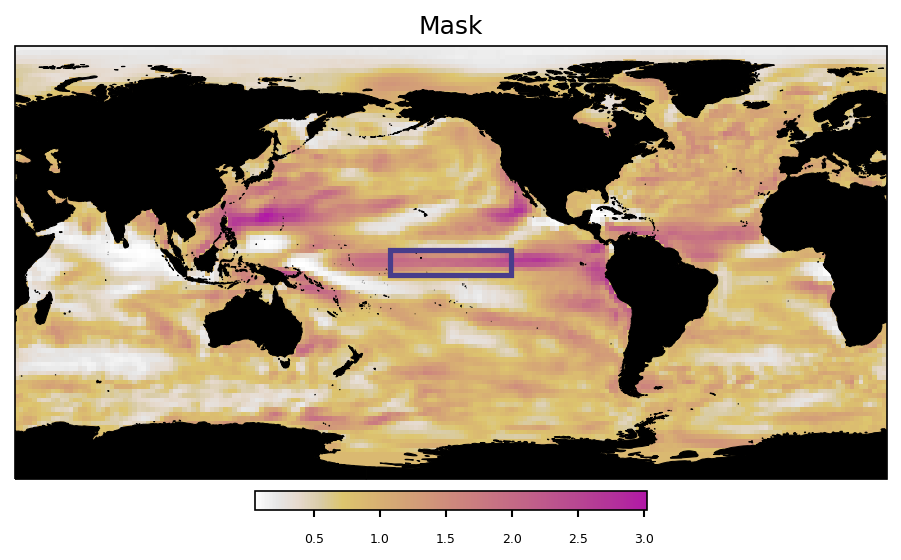

In [101]:
exp_name = 'exp300'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()

settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])
# Get the mask
mask = model.get_layer("mask_model").get_layer("weights_layer").bias.numpy().reshape(analog_input[0].shape)
imp.reload(metrics)

n_processes = 8
n_analogues = 15
soi_input = soi_test_input
soi_output = soi_test_output
# MAKE SUMMARY PLOT ACROSS ALL MODEL TYPES
rng_string = settings["savename_prefix"][settings["savename_prefix"].find('rng'):]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4 * 1.6), gridspec_kw={'height_ratios': [5, 3], 'hspace' : .5})
i_rng, rng_string = 0, "rng_seed_0"

# GET THE METRICS DATA
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + "_interp_model_" + rng_string + '_metrics.pickle', 'rb') as f:
    plot_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_analog_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_analog_metrics = pickle.load(f)
with open(dir_settings["metrics_directory"] + settings[
    "exp_name"] + '_ann_model_' + rng_string + '_metrics.pickle', 'rb') as f:
    ann_metrics = pickle.load(f)

# PLOT THE METRICS
sub = plt.subplot(2, 1, 1)

n_analogs_list = np.array([1, 2, 5, 10, 15, 20, 25, 30, 50])
i_n_analogs = np.argwhere(n_analogs_list == n_analogues)

plots.summarize_skill_score(plot_metrics)

plot_ann_metrics = ann_analog_metrics
y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_network"][i_n_analogs]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
print(y_plot)
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.8, label="ann analog")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_persist"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.2, label="persistence")

y_plot = 1. - metrics.eval_function(plot_ann_metrics["error_custom"]) / metrics.eval_function(
    plot_ann_metrics["error_climo"])
plt.axhline(y=y_plot, linestyle='--', color="teal", alpha=.5, label="custom")

plt.text(0.0, .99, ' ' + settings["exp_name"] + "_interp_model_" + rng_string + '\n smooth_time: ['
            + str(settings["smooth_len_input"]) + ', ' + str(settings["smooth_len_output"]) + '], leadtime: '
            + str(settings["lead_time"]),
            fontsize=6, color="gray", va="top", ha="left", fontfamily="monospace",
            transform=plt.gca().transAxes)
plt.grid(False)
plt.ylim(-.3, .4)

# Remove some lines
lines = sub.get_lines()
for line in [4, 6, 7]:
    lines[line].remove()

# Update some line labels
lines[0].set_label('climatology')
lines[2].set_label('niño3.4 corr.')
lines[3].set_label('indopac corr.')
lines[8].set_label('mean evolution')

# Change a color
lines[2].set_color('deepskyblue')
lines[3].set_color('mediumblue')
lines[8].set_color('lightgray')
lines[8].set_alpha(1)

# Change order
lines[8].set_zorder(0)
lines[3].set_zorder(0)

plt.legend(fontsize=8, loc=4, ncol=2)
plt.xticks(n_analogs_list)

# This stuff just keeps the second subplot the exact same as in Figure 3
plt.subplot(2, 1, 2)

plt.ylabel('SST anomaly (˚C)')
plt.xlabel('year')
plt.xlim(0, 49)
plt.xticks(np.arange(10,50,10))
plt.yticks([-2, 0, 2])

fig_savename = 'Figure4b'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')
#^ Note, keeping two panels here so it has the same shape as the one in the first part of the paper.
ax = dict()

fig = plt.figure(figsize=(7.5 * 1, 5))

# Plotting the region box specs
edgecolor = 'darkslateblue'
region_bool = True
climits = [mask.min(), mask.max()]
ax, _ = plots.plot_interp_masks(fig, settings, mask[..., 0], lat=lat, lon=lon, cmap=None,
                                    central_longitude=215., climits = climits, title_text="Mask",
                                    subplot=(1, 1, 1), use_text=False, 
                                    region_bool=region_bool, edgecolor = edgecolor)

fig_savename = 'Figure4a'
plt.savefig(dir_settings["figure_custom_directory"] + settings["savename_prefix"] +
                    '_' + fig_savename + '.png', dpi=300, bbox_inches='tight')

# What do the observations look like?

In [190]:
imp.reload(build_data)

<module 'build_data' from '/Users/Jamin/Library/CloudStorage/GoogleDrive-jaminrader.science@gmail.com/My Drive/2022/ConstrainingEnsembleProjections/constraining_ensemble_projections/build_data.py'>

In [191]:
exp_name = 'exp300'
model_type = 'interp_model'
dir_settings = base_directories.get_directories()

settings = experiments.get_experiment(exp_name)
settings['rng_seed'] = 0
settings['model_type'] = model_type

(
    analog_input,
    analog_output,
    soi_train_input,
    soi_train_output,
    soi_val_input,
    soi_val_output,
    soi_test_input,
    soi_test_output,
    input_standard_dict,
    output_standard_dict,
    lat,
    lon,
) = build_data.build_data(settings, dir_settings["data_directory"])

savename_prefix = (
        exp_name
        + "_" + settings["model_type"] + "_"
        + f"rng_seed_{settings['rng_seed']}"
)
settings["savename_prefix"] = savename_prefix

model = save_load_model_run.load_model(settings, settings["savename_prefix"],
                                      [soi_train_input, analog_input])

loading the pre-saved training/validation/testing data.
   /Users/Jamin/LocalData/constraining_ensemble_projections/big_data/presaved_data_exp300.pickle
   analog data
 # analog samples = 5390
   training data
 # soi samples = 2310
   validation data
   # soi samples = 770
   testing data
  # soi samples = 770



In [192]:
# How much, at the end of the period, do we use for obs? Minus the years lost due to prediction leads
#part_obs_size = np.arange(1940, 2006, ).size - (np.arange(1850, 2006, ).size - input_standard_dict["ens_mean"].shape[0])
num_correction_yrs = 50
actual_data_amount_diff = (np.arange(1850, 2006, ).size - input_standard_dict["ens_mean"].shape[0])
obs_size = np.arange(1940, 2023, ).size - actual_data_amount_diff

# Create observation standard dicts
#mpi_input_standard_dict = input_standard_dict.copy()
#mpi_input_standard_dict['ens_mean'] = np.zeros_like(input_standard_dict['ens_mean'][-obs_size:].copy())
#mpi_output_standard_dict = output_standard_dict.copy()
#mpi_output_standard_dict['ens_mean'] = np.zeros_like(output_standard_dict['ens_mean'][-obs_size:].copy())
none_input_standard_dict = dict()
none_output_standard_dict = dict()
none_input_standard_dict['ens_mean'] = np.zeros_like(input_standard_dict['ens_mean'][-(obs_size):].copy())
none_output_standard_dict['ens_mean'] = np.zeros_like(output_standard_dict['ens_mean'][-(obs_size):].copy())
none_input_standard_dict['data_mean'] = None
none_input_standard_dict['data_std'] = None
none_output_standard_dict['data_mean'] = None
none_output_standard_dict['data_std'] = None


In [193]:
# Pass obs_info
obs_info = {
    'target_filename' : 'skt_era5_1940-2022_rMPI-GE.nc',
    'target_var' : "skt",
    'feature_filename' : 'skt_era5_1940-2022_rMPI-GE.nc',
    'feature_var' : "skt",
    'input_standard_dict' : none_input_standard_dict.copy(),
    'output_standard_dict' : none_output_standard_dict.copy(),
    
}

In [194]:
# Get the observed data
settings['standardize_bool'] = False # don't standardize for now... need raw(ish) data
obs_input, obs_output, __, __, __, __ = \
    build_data.build_obs_data(settings, dir_settings["data_directory"], obs_info)
settings['standardize_bool'] = True 

getting observations...


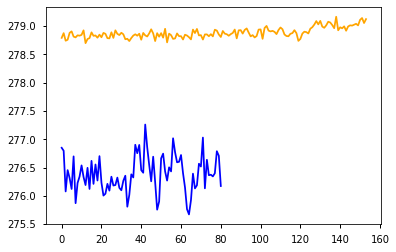

In [195]:
# Bias-correcting the ensemble mean assessment
plt.plot(input_standard_dict['ens_mean'][:, 20, 20, 0], label='original ens mean', color = 'orange')
plt.plot(obs_input[:, 20, 20, 0], label='observations', color = 'blue')
plt.show()

In [196]:
nlats = obs_input.shape[1]
nlons = obs_input.shape[2]

# Initializing the mpi2obs_input_standard_dict, mpi2obs_output_standard_dict
obs_input_standard_dict = dict()
obs_output_standard_dict = dict()
obs_input_standard_dict['ens_mean'] = np.full((obs_size, nlats, nlons, 1), np.nan)
obs_input_standard_dict['data_mean'] = np.full((obs_size, nlats, nlons, 1), np.nan)
obs_input_standard_dict['data_std'] = np.full((obs_size, nlats, nlons, 1), np.nan)
obs_output_standard_dict['ens_mean'] = np.full((obs_size,), np.nan)
obs_output_standard_dict['data_mean'] = np.full((obs_size,), np.nan)
obs_output_standard_dict['data_std'] = np.full((obs_size,), np.nan)

# Landmask, so we don't compute bias correction for those locations
mask = model.get_layer("mask_model").get_layer("weights_layer").bias.numpy().reshape(analog_input[0].shape)
landmask = build_data.maskout_land_ocean(np.ones_like(mask).squeeze(), maskout="land").squeeze()[..., None]

# Bias correct the ensemble mean for input data
x = np.arange(num_correction_yrs)
for iyr in range(obs_size - num_correction_yrs):
    for ilat in range(nlats):
        for ilon in range(nlons):
            #if landmask[ilat, ilon, 0] == 1:
            try:
                y = obs_input[iyr:iyr+num_correction_yrs, ilat, ilon, 0] # observations, 1940-2005
                coeffs = np.polyfit(x, y, 1)
                ens_mean_next_year = num_correction_yrs * coeffs[0] + coeffs[1]
                y_ens_mean = np.arange(num_correction_yrs)* coeffs[0] + coeffs[1]
                obs_input_standard_dict['ens_mean'][iyr+num_correction_yrs, ilat, ilon, 0] = ens_mean_next_year
                obs_input_standard_dict['data_mean'][iyr+num_correction_yrs, ilat, ilon, 0] = np.mean(y - y_ens_mean, axis=0)
                obs_input_standard_dict['data_std'][iyr+num_correction_yrs, ilat, ilon, 0] = np.std(y, axis=0)
            except:
                pass

    # Bias correct the output
    y = obs_output[iyr: iyr+num_correction_yrs]
    coeffs = np.polyfit(x, y, 1)
    ens_mean_next_year = num_correction_yrs * coeffs[0] + coeffs[1]
    y_ens_mean = np.arange(num_correction_yrs)* coeffs[0] + coeffs[1]
    obs_output_standard_dict['ens_mean'][iyr+num_correction_yrs] = ens_mean_next_year
    obs_output_standard_dict['data_mean'][iyr+num_correction_yrs] = np.mean(y - y_ens_mean)
    obs_output_standard_dict['data_std'][iyr+num_correction_yrs] = np.std(y)

# Concatenate nans for first num_correction_yrs
# obs_input_standard_dict['ens_mean'] = np.concatenate([np.full((num_correction_yrs,) + obs_input_standard_dict['ens_mean'].shape[1:], np.nan), 
#                                                      obs_input_standard_dict['ens_mean'].copy()])
# obs_input_standard_dict['data_mean'] = np.concatenate([np.full((num_correction_yrs,) + obs_input_standard_dict['data_mean'].shape[1:], np.nan), 
#                                                      obs_input_standard_dict['data_mean'].copy()])
# obs_input_standard_dict['data_std'] = np.concatenate([np.full((num_correction_yrs,) + obs_input_standard_dict['data_std'].shape[1:], np.nan), 
#                                                      obs_input_standard_dict['data_std'].copy()])
# obs_output_standard_dict['ens_mean'] = np.concatenate([np.full((num_correction_yrs,) + obs_output_standard_dict['ens_mean'].shape[1:], np.nan), 
#                                                      obs_output_standard_dict['ens_mean'].copy()])
# obs_output_standard_dict['data_mean'] = np.concatenate([np.full((num_correction_yrs,) + obs_output_standard_dict['data_mean'].shape[1:], np.nan), 
#                                                      obs_output_standard_dict['data_mean'].copy()])
# obs_output_standard_dict['data_std'] = np.concatenate([np.full((num_correction_yrs,) + obs_output_standard_dict['data_std'].shape[1:], np.nan), 
#                                                      obs_output_standard_dict['data_std'].copy()])

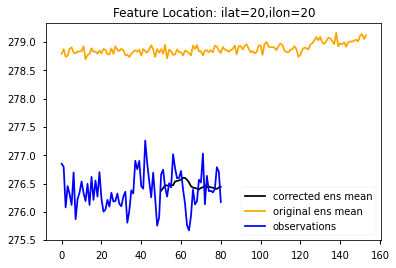

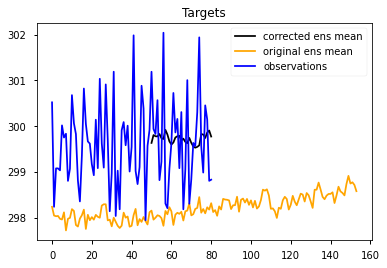

In [197]:
plt.plot(obs_input_standard_dict['ens_mean'][:, 20, 20, 0], label='corrected ens mean', color = 'black')
plt.plot(input_standard_dict['ens_mean'][:, 20, 20, 0], label='original ens mean', color = 'orange')
plt.plot(obs_input[:, 20, 20, 0], label='observations', color = 'blue')
plt.legend()
plt.title('Feature Location: ilat=20,ilon=20')
plt.show()

plt.plot(obs_output_standard_dict['ens_mean'], label='corrected ens mean', color = 'black')
plt.plot(output_standard_dict['ens_mean'], label='original ens mean', color = 'orange')
plt.plot(obs_output, label='observations', color = 'blue')
plt.legend()
plt.title('Targets')
plt.show()

In [198]:
obs_info['input_standard_dict'] = obs_input_standard_dict.copy()
obs_info['output_standard_dict'] = obs_output_standard_dict.copy()

final_obs_input, final_obs_output, __, __, __, __ = \
    build_data.build_obs_data(settings, dir_settings["data_directory"], obs_info)



getting observations...


In [199]:
# Get the mask
mask = model.get_layer("mask_model").get_layer("weights_layer").bias.numpy().reshape(analog_input[0].shape)
imp.reload(metrics)

n_processes = 8
n_analogues = 15
soi_input = final_obs_input
soi_output = final_obs_output

obs_predictions = np.zeros((3, soi_input.shape[0])).T * np.nan

with Pool(n_processes) as pool:
    soi_iterable_instance = model_diagnostics.soi_iterable(n_analogues,
                                                            soi_input,
                                                            soi_output,
                                                            analog_input,
                                                            analog_output,
                                                            mask)
    obs_predictions[:,:]  = model_diagnostics.run_complex_operations(metrics.test_predictions,
                                                    soi_iterable_instance,
                                                    pool,
                                                    chunksize=soi_input.shape[0]//n_processes,)

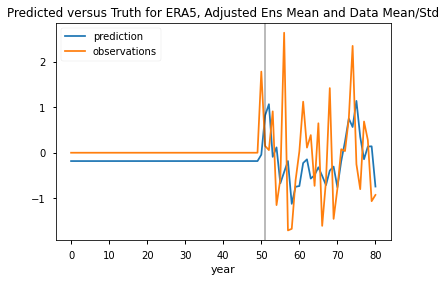

MAE Skill Score:  0.015948395708860197
Correlation:  0.256580686700411


In [200]:
plt.plot(obs_predictions[:, 0], label = 'prediction')
plt.plot(final_obs_output, label = 'observations')
plt.legend()
plt.title('Predicted versus Truth for ERA5, Adjusted Ens Mean and Data Mean/Std')
plt.xlabel('year')
plt.axvline(num_correction_yrs + 1, color = 'black', alpha = .3)
plt.show()

mae_obs_pred = np.mean(np.abs(obs_predictions[num_correction_yrs:, 0] - final_obs_output[num_correction_yrs:]))
mae_obs_climo = np.mean(np.abs(np.mean(final_obs_output[num_correction_yrs:]) - final_obs_output[num_correction_yrs:]))
print('MAE Skill Score: ', 1 - (mae_obs_pred/mae_obs_climo))
print('Correlation: ', np.corrcoef(obs_predictions[num_correction_yrs:, 0], final_obs_output[num_correction_yrs:])[0,1])
